In [40]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json

In [41]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [42]:
raw_df = pd.read_csv("../log/stat.csv")
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df.head()

,time,level,file,line,msg,pkt_count,tcp_pkt_count_tot,udp_pkt_count_tot,icmp_pkt_count_tot,unsupported_pkt_count,...,replied_flow_count_tot,replied_flow_count_tcp,replied_flow_count_udp,replied_flow_count_icmp,expired_pkt_count_tot,expired_pkt_count_tcp,expired_pkt_count_udp,expired_pkt_count_icmp,active_host_tbl_entry_count,send_pkt_error_count
0,0.000000,STATS,src/tsdn.c,492,pkt_processing_time,1000,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.007209,STATS,src/tsdn.c,492,pkt_processing_time,2000,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.012166,STATS,src/tsdn.c,492,pkt_processing_time,3000,33.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.017770,STATS,src/tsdn.c,492,pkt_processing_time,4000,31.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.027280,STATS,src/tsdn.c,492,pkt_processing_time,5000,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df.reset_index(inplace=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True)
print(timeout_df.head())

   index      time  sample_at  pkt_process_time
0      0  0.000000       1000              16.0
1      1  0.007209       2000              32.0
2      2  0.012166       3000              33.0
3      3  0.017770       4000              31.0
4      4  0.027280       5000              15.0
   index      time  timeout
0     10  0.080075    26536
1     17  0.143338    21648
2     23  0.226708    29610
3     29  0.325349    39903
4     33  0.385632    25010


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

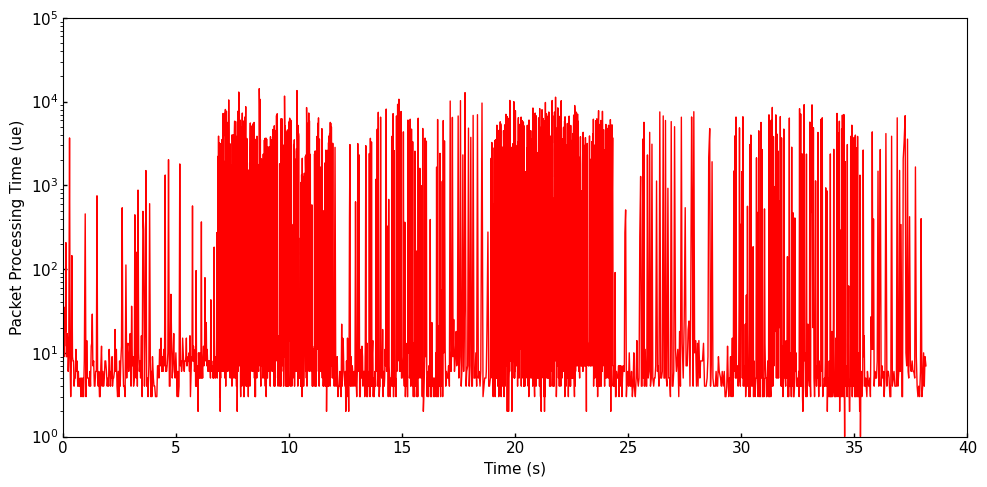

In [44]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              yscale='log',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (ue)')

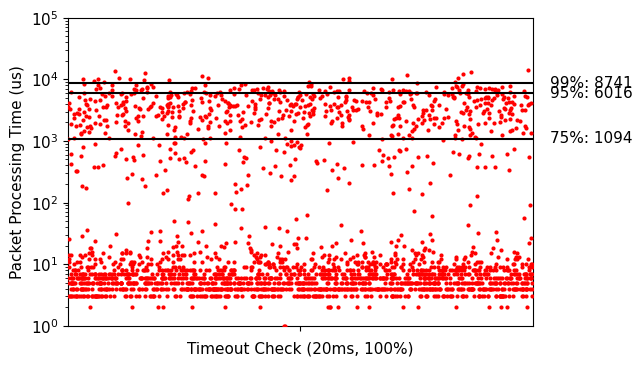

In [45]:
plt.figure(figsize=(6, 4))
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (20ms, 100%)')
plt.yscale('log')


texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.25, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

([Text(0.16285282258064515, 34702.996753246756, '75%: 34825'),
  Text(0.16270161290322582, 38841.16688311688, '95%: 39146'),
  Text(0.1626008064516129, 40022.58662337663, '99%: 39962')],
 [])

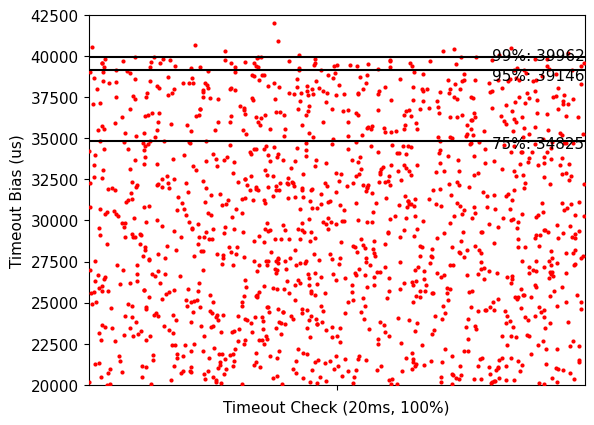

In [46]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (20ms, 100%)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [47]:
from cycler import cycler

mcolor_lists = ['red', 'red', 'blue', 'blue', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<Figure size 640x480 with 0 Axes>

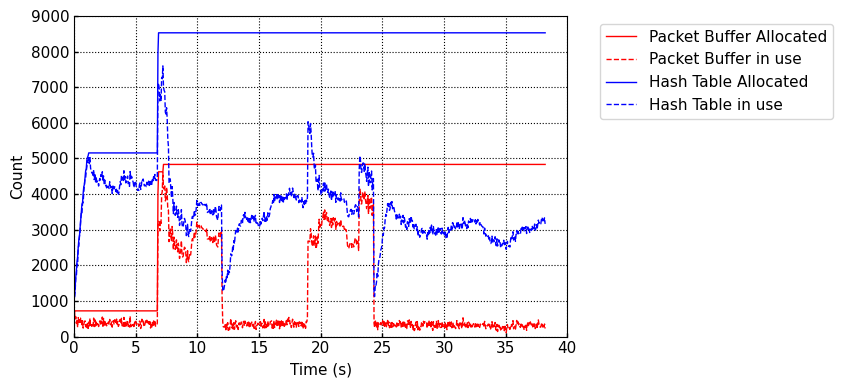

In [48]:
# buffered packet count

fastplot.plot([('Packet Buffer Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

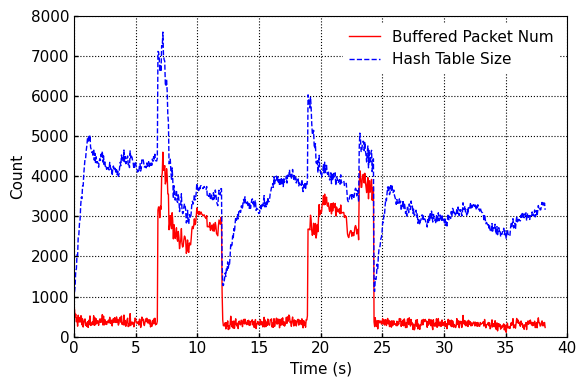

In [49]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

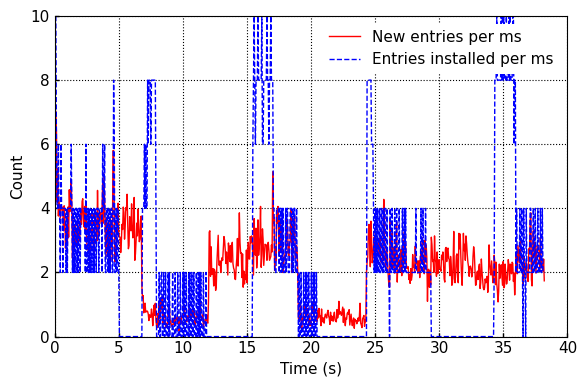

In [50]:
new_entry_cnt_ms = stats_df['replied_flow_count_tot'].diff()[1:].apply(lambda x: x/50)
instal_entry_cnt_ms = stats_df['installed_entry_count_tot'].diff()[1:].apply(lambda x: x/50)

fastplot.plot([('New entries per ms', (stats_df['time'][1:], new_entry_cnt_ms)),
                ('Entries installed per ms', (stats_df['time'][1:], instal_entry_cnt_ms))],
                None,
                mode='line_multi',
                legend=True, legend_loc='best',
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Count')

# Data Plane Resource Usage

## Table Entry Count

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

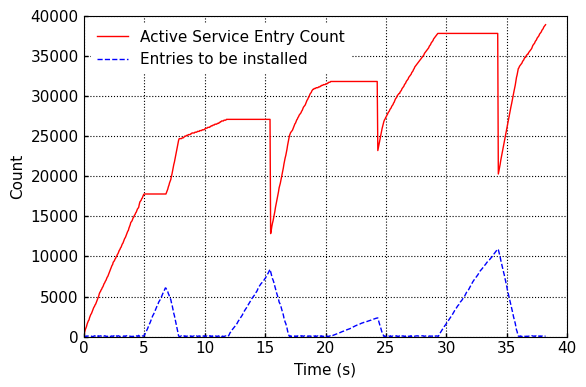

In [51]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count'])),
               ('Entries to be installed', (stats_df['time'], stats_df['install_buf_size']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [52]:
recv_speed_df = []

with open('../log/recv_speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            recv_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

recv_speed_df = pd.DataFrame(recv_speed_df)
recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].astype(float)

recv_speed_df = recv_speed_df.drop(recv_speed_df[recv_speed_df['rx_speed']==0].index)
recv_speed_df['time'] = recv_speed_df['time'] - recv_speed_df['time'].min()

print(recv_speed_df.head())

send_speed_df = []

with open('../log/send_speed_log.json', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'jsonversion' not in line and 'maxratestring' not in line:
            line = json.loads(line)
            send_speed_df.append({'time': line['seconds'], 'tx_speed': line['tx']['ratestring']})

send_speed_df = pd.DataFrame(send_speed_df)
# send_speed_df['rx_speed'] = send_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# send_speed_df['rx_speed'] = send_speed_df['rx_speed'].astype(float)
send_speed_df['tx_speed'] = send_speed_df['tx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
send_speed_df['tx_speed'] = send_speed_df['tx_speed'].astype(float)

send_speed_df = send_speed_df.drop(send_speed_df[send_speed_df['tx_speed']==0].index)
send_speed_df['time'] = send_speed_df['time'] - send_speed_df['time'].min()

send_speed_df.head()

   time  rx_speed
0     0   0.03789
1     2   0.07902
2     4   0.06657
3     6   0.10535
4     8   0.27583


,time,tx_speed
3,0,0.79309
4,2,1.67000
5,4,1.68000
6,6,1.64000
7,8,0.85122


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

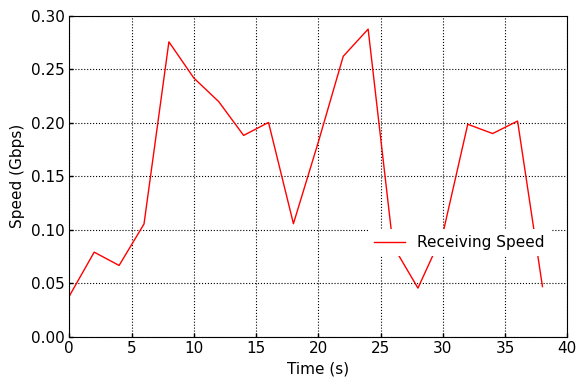

In [54]:
fastplot.plot([
    # ('Sending Speed', (send_speed_df['time'], send_speed_df['tx_speed'])),
              ('Receiving Speed', (recv_speed_df['time'], recv_speed_df['rx_speed']))],
                None,
                mode='line_multi',
                legend=True, legend_loc=[0.6, 0.25],
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Speed (Gbps)')